In [1]:
import os, tempfile
import logging

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.ical_li import (li_iv_80,
                                 li_iv_80_norm,
                                 li_iv_60,
                                 li_iv_40,
                                 li_act,
                                 li_inact_1000,
                                 li_inact_300,
                                 li_inact_150,
                                 li_inact_kin_80,
                                 li_inact_kin_60,
                                 li_inact_kin_40,
                                 li_recov
                                 )

In [5]:
modelfile = 'models/nygren_ical.mmt'

# d gate -> Only activation data

In [13]:
observations, model, summary_statistics = setup(modelfile,
                                                li_iv_80_norm)

In [14]:
assert len(observations)==len(summary_statistics(model({})))

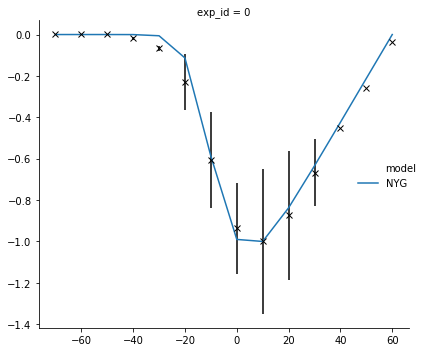

In [16]:
g = plot_sim_results(modelfile,
                     li_iv_80_norm)
                    #li_iv_60,
                    #li_iv_40,
                    #li_act,
                    #li_inact_1000,
                    #li_inact_300,
                    #li_inact_150,
                    #li_inact_kin_80,
                    #li_inact_kin_60,
                    #li_inact_kin_40,
                    #li_recov)

In [32]:
limits = {'ical.p1': (-50, 50),
          'ical.p2': (0, 50),
          'log_ical.p3': (-7, 3),
          'ical.p4': (0, 100),
          'ical.p5': (0, 50),
          'log_ical.p6': (-7, 3)}
          #'ical.q1': (0, 100),
          #'ical.q2': (0, 50),
          #'log_ical.q3': (-2, 0),
          #'ical.q4': (0, 100),
          #'ical.q5': (0, 50),
          #'log_ical.q6': (-3, -1),
          #'log_ical.r1': (-1, 1),
          #'ical.r2': (0, 100),
          #'ical.r3': (0, 100),
          #'log_ical.r4': (-3, -1)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [33]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "nygren_ical_d_reported.db"))

In [34]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [35]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


In [36]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(500),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=4),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.4859671137278196, '1': 1.4859671137278196, '2': 1.4859671137278196, '3': 1.4859671137278196, '4': 1.4859671137278196, '5': 0.5462412219695316, '6': 0.3185914562515139, '7': 0.33736587501899584, '8': 0.21240524894270255, '9': 0.23895282672359947, '10': 0.4587064612710979, '11': 1.4859671137278196, '12': 1.4859671137278196, '13': 1.4859671137278196}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=20, quantile_multiplier=1


In [37]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [38]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-10-02 17:55:27.186746, end_time=None)>


In [39]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 503
DEBUG:Epsilon:new eps, t=1, eps=0.3229407524770708
INFO:ABC:t:1 eps:0.3229407524770708
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 1474
DEBUG:Epsilon:new eps, t=2, eps=0.24183186167553197
INFO:ABC:t:2 eps:0.24183186167553197
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 2866
DEBUG:Epsilon:new eps, t=3, eps=0.2157522006053198
INFO:ABC:t:3 eps:0.2157522006053198
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 4859
DEBUG:Epsilon:new eps, t=4, eps=0.18858854286506355
INFO:ABC:t:4 eps:0.18858854286506355
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 7292
DEBUG:Epsilon:new eps, t=5, eps=0.1638994359

### Database results analysis

In [40]:
history = History(db_path)

In [41]:
df, w = history.get_distribution(m=0)

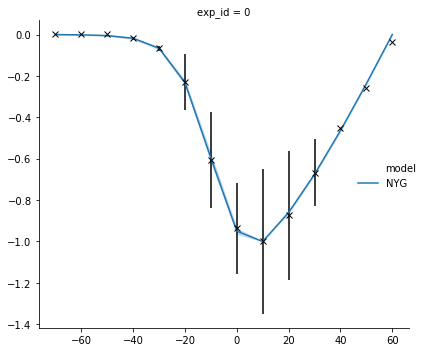

In [42]:
g = plot_sim_results(modelfile,
                     li_iv_80_norm,
                     df=df, w=w)

In [43]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [44]:
m,_,_ = myokit.load(modelfile)

In [45]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

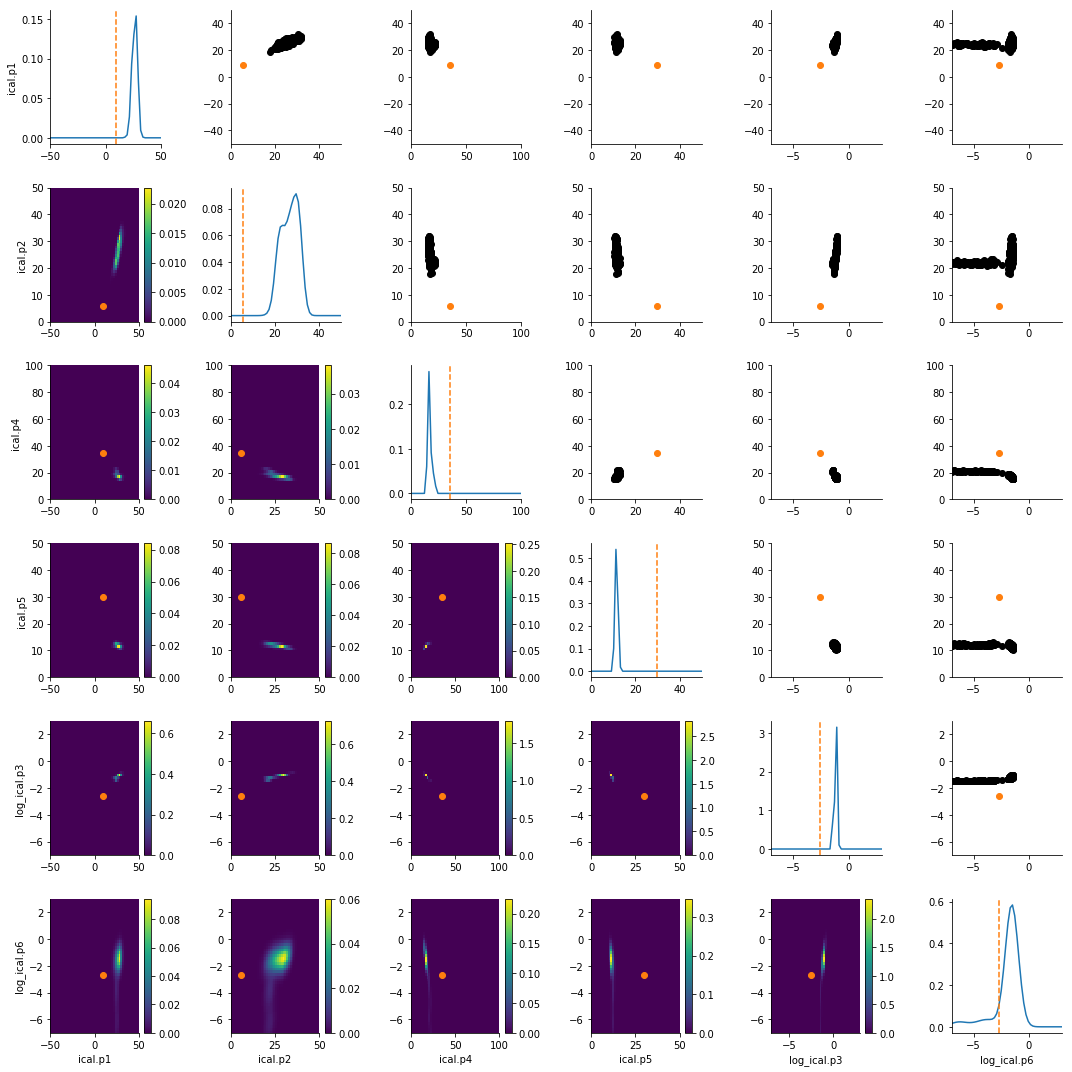

In [46]:
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

# f gate -> Inactivation

In [6]:
observations, model, summary_statistics = setup(modelfile,
                                                li_inact_1000,
                                                li_inact_kin_80,
                                                li_recov)

In [7]:
assert len(observations)==len(summary_statistics(model({})))

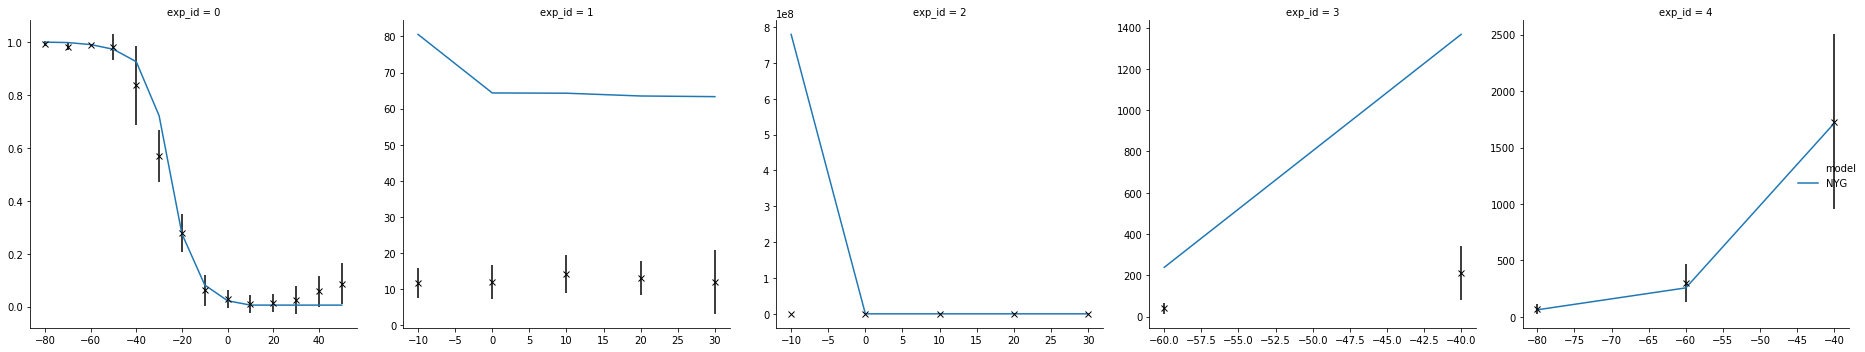

In [8]:
g = plot_sim_results(modelfile,
                     #li_iv_80_norm)
                    #li_iv_60,
                    #li_iv_40,
                    #li_act,
                    li_inact_1000,
                    #li_inact_300,
                    #li_inact_150,
                    li_inact_kin_80,
                    #li_inact_kin_60,
                    #li_inact_kin_40,
                    li_recov)

In [14]:
limits = {#'ical.p1': (-50, 50),
          #'ical.p2': (0, 50),
          #'log_ical.p3': (-7, 3),
          #'ical.p4': (0, 100),
          #'ical.p5': (0, 50),
          #'log_ical.p6': (-7, 3)}
          'ical.q1': (0, 100),
          'ical.q2': (0, 50),
          'log_ical.q3': (-7, 3),
          'ical.q4': (0, 100),
          'ical.q5': (0, 50),
          'log_ical.q6': (-7, 3),
          'log_ical.r1': (-7, 3),
          'ical.r2': (0, 100),
          'ical.r3': (0, 100),
          'log_ical.r4': (-7, 3)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [15]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "nygren_ical_f_reported.db"))

In [16]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [17]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [18]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=4),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9837148289810967, '1': 0.9837148289810967, '2': 0.9837148289810967, '3': 0.9837148289810967, '4': 0.3255918060516033, '5': 0.5055241199222262, '6': 0.6753486289586007, '7': 0.8392681990941822, '8': 0.9837148289810967, '9': 0.9837148289810967, '10': 0.9837148289810967, '11': 0.9196236649649016, '12': 0.8392681990941822, '13': 0.6309826606328519, '14': 0.46084783444382477, '15': 0.4184561967200059, '16': 0.36886776090803813, '17': 0.4191992497796024, '18': 0.21952975590454923, '19': 0.5102122707484875, '20': 0.7659862673065287, '21': 0.4791367008919785, '22': 2.754401521147071, '23': 0.21885528270246793, '24': 2.749064693405502, '25': 0.5560031468540616, '26': 4.590669201911785, '27': 2.354305935366494, '28': 0.5128531003233774}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [19]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [21]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-02 18:44:47.831282, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


### Database results analysis

In [23]:
history = History(db_path)

In [24]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-10-02 18:44:47.831282, end_time=2019-10-04 10:06:05.609505)>]

In [25]:
df, w = history.get_distribution(m=0)

In [26]:
df.describe()

name,ical.q1,ical.q2,ical.q4,ical.q5,ical.r2,ical.r3,log_ical.q3,log_ical.q6,log_ical.r1,log_ical.r4
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,30.685961,4.935450,47.216021,25.700885,44.891125,10.249415,-2.714706,-1.846294,-0.103171,-1.701712
std,4.698852,1.110868,25.538334,13.057803,6.616855,4.257766,2.248808,1.545187,0.366763,0.037705
min,19.346003,2.237096,0.389196,0.029097,28.778927,1.073041,-6.993157,-6.911928,-0.877485,-1.809899
25%,27.324037,4.144278,26.148709,15.266050,39.696081,7.238284,-4.616998,-1.987062,-0.431994,-1.726613
50%,30.501415,4.889883,46.369370,26.191308,43.452077,9.516003,-2.407076,-1.527072,-0.053889,-1.703539
75%,33.936639,5.710709,67.049222,36.265395,51.124898,12.858310,-0.863306,-0.888635,0.161447,-1.679367
max,46.871593,8.939247,99.887911,49.831161,59.679218,21.394599,2.962870,2.839259,1.154914,-1.586600


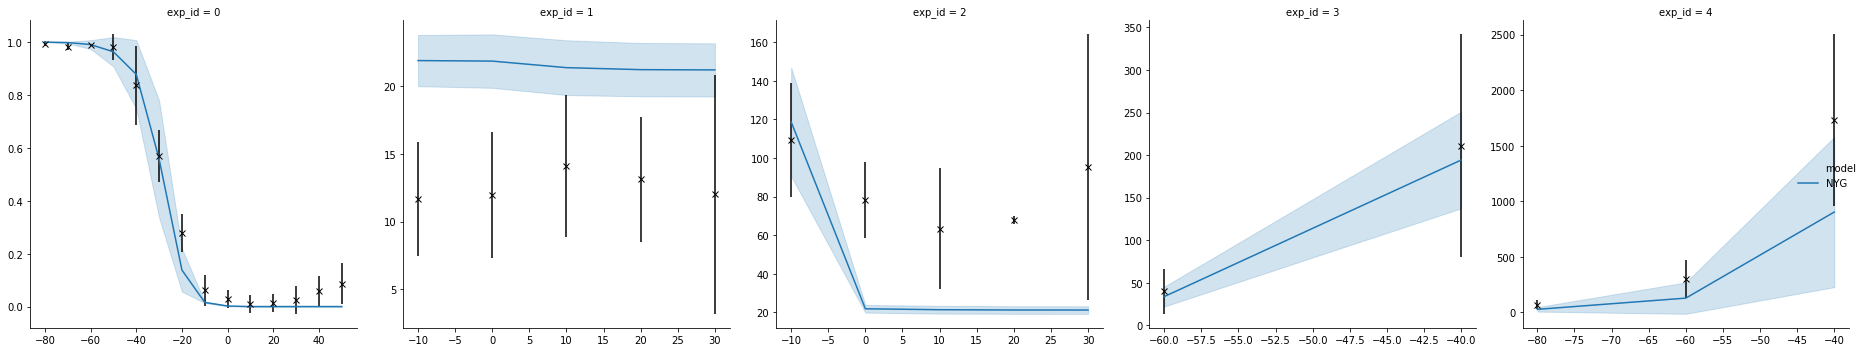

In [27]:
g = plot_sim_results(modelfile,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov,
                     df=df, w=w)

In [28]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [29]:
m,_,_ = myokit.load(modelfile)

In [30]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

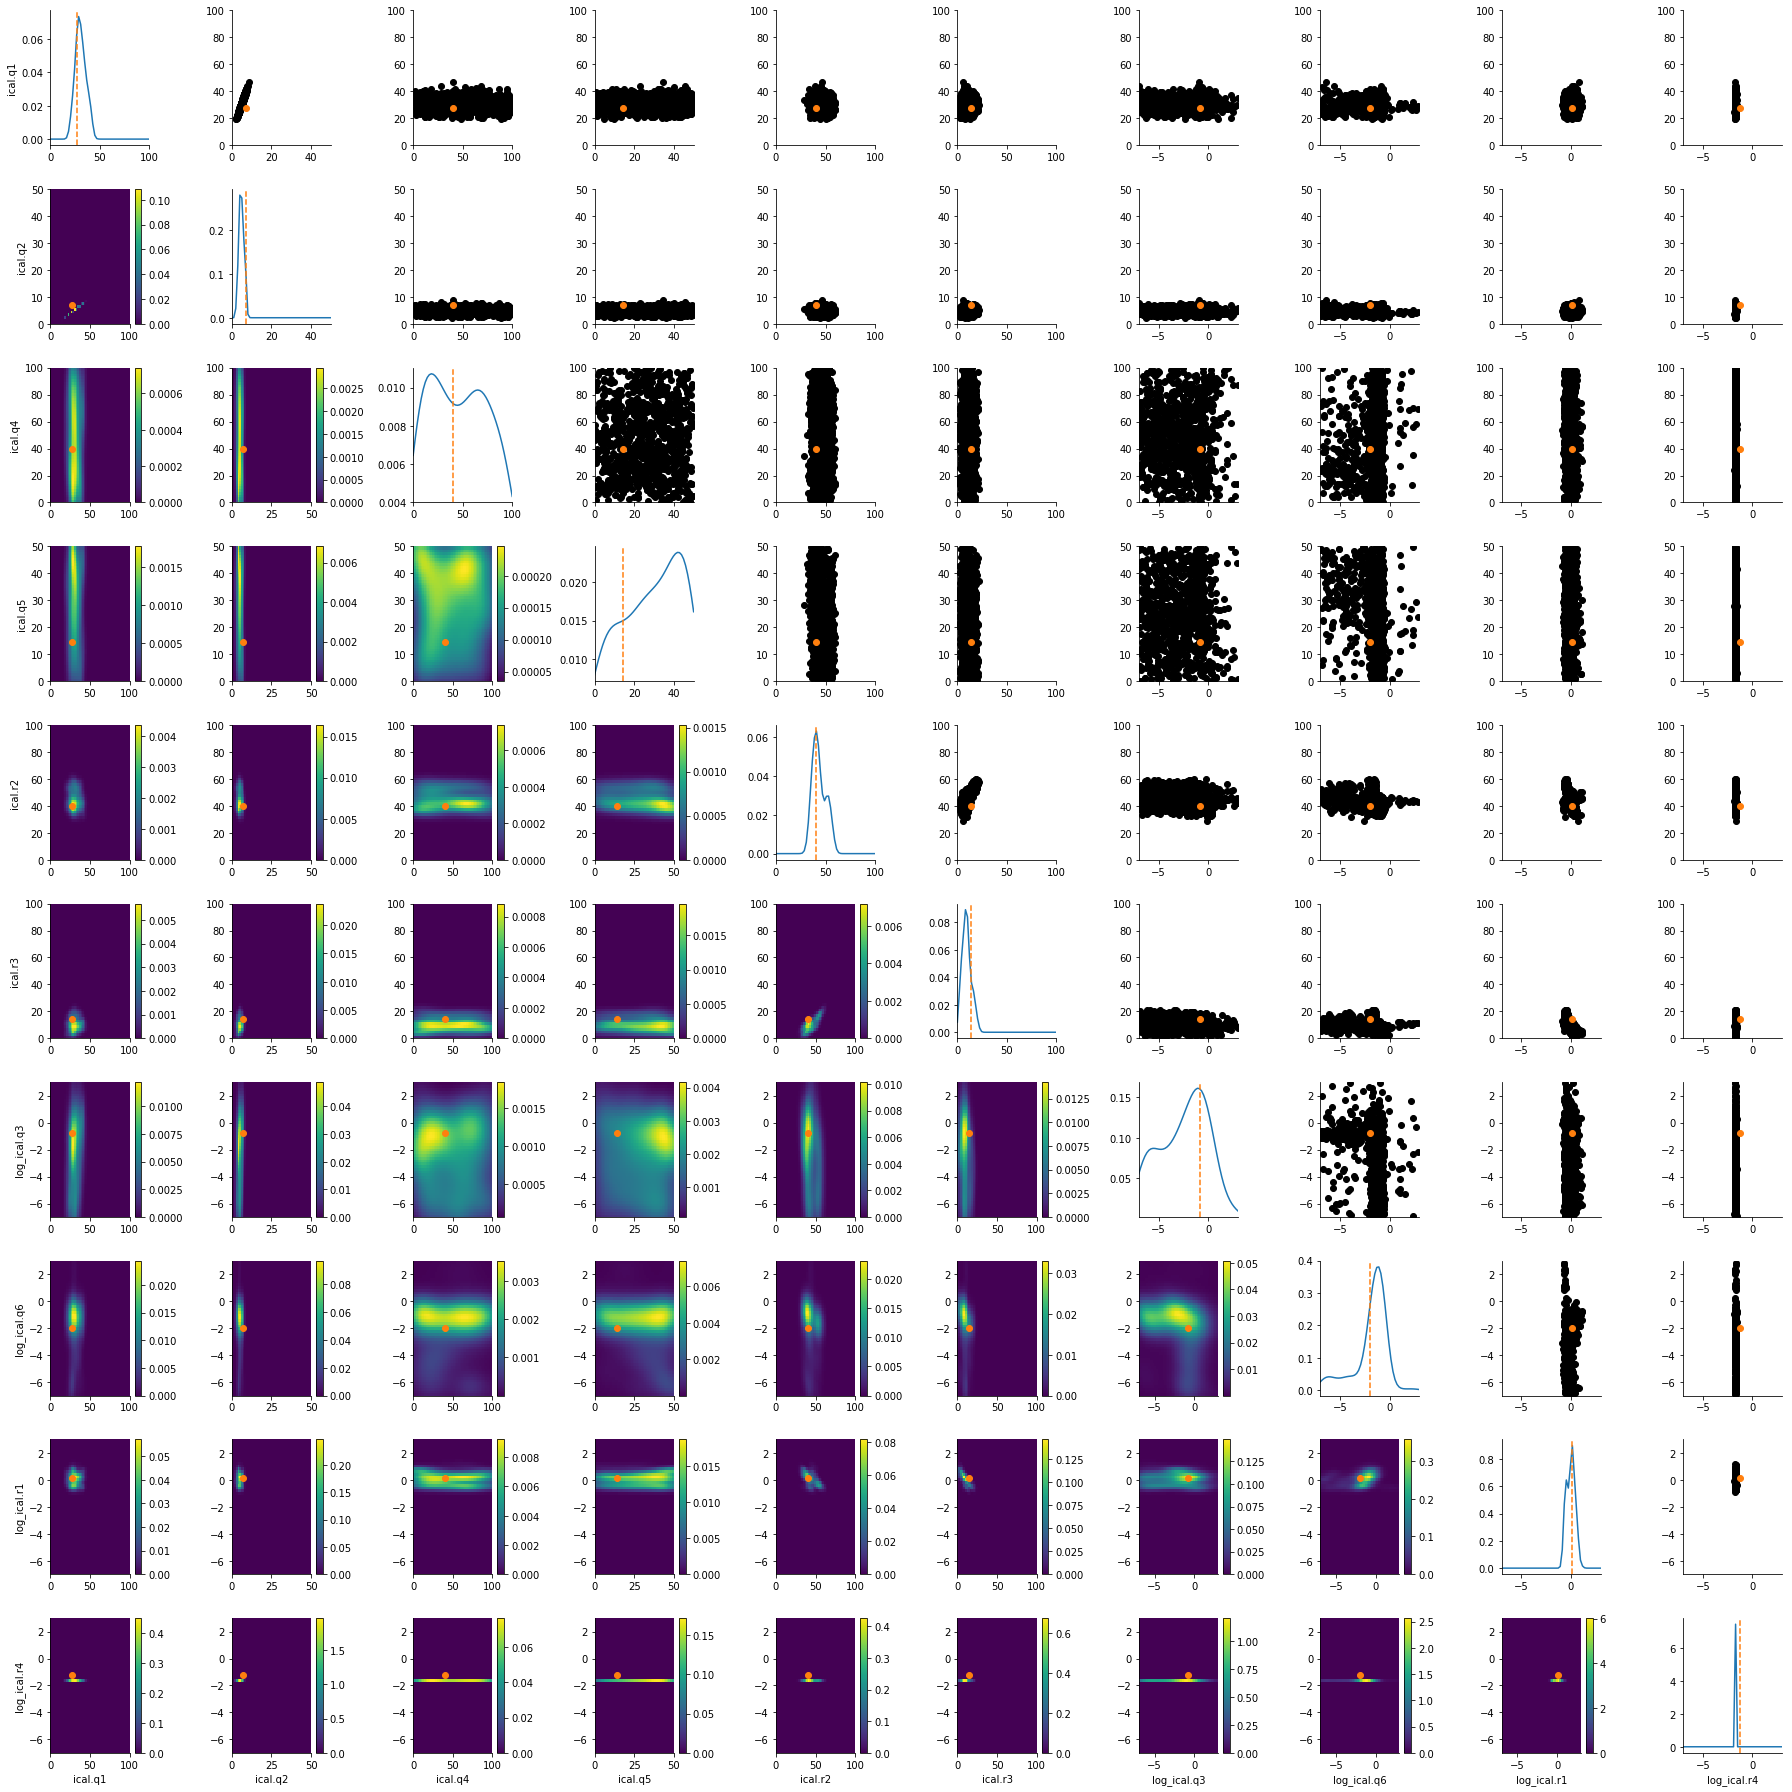

In [31]:
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)